In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Effective magnetic field plots (Morales-Durán et al.)

Goal: follow the computations in the paper and, using the same symbols, plot the relevant parameters of the bilayer Hamiltonian and the effective magnetic field obtained from it.

Paper https://arxiv.org/pdf/2308.03143.pdf

### Parameters and grid

In [3]:
## Parameters: start with everything set to 1 except the angle
# What I call V is V_m in the text, what I call w is omega in text, what I call k is k_theta in text

V = 1
phi = 89.6 * np.pi / 180
w = 1
a_M = 1
k = 4 * np.pi * a_M / np.sqrt(3)

# 2-vectors G_j used to define the interlayer potentials
G_1 = k * np.array([np.cos(np.pi * 1 / 3), np.sin(np.pi * 1 / 3)])
G_2 = k * np.array([np.cos(np.pi * 2 / 3), np.sin(np.pi * 2 / 3)])
G_3 = k * np.array([np.cos(np.pi * 3 / 3), np.sin(np.pi * 3 / 3)])
G_5 = k * np.array([np.cos(np.pi * 5 / 3), np.sin(np.pi * 5 / 3)])
# additional 2-vector q_j
q_1 = k *  np.array([0, -1 / np.sqrt(3)])
q_2 = G_2 + q_1
q_3 = G_3 + q_1

In [4]:
# Get an xy grid (in units of a_M = 1)
N = 1000
x = a_M * np.linspace(-1.5, 1.5, N, endpoint=True)
y = a_M * np.linspace(-1.5, 1.5, N, endpoint=True)
xx, yy = np.meshgrid(x, y)

### Potentials and derived fields

In [5]:
# Three potentials: bottom layer, top layer, tunnelling
Del_b = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        r = np.array([xx[i,j], yy[i,j]])
        Del_b[i,j] = 2 * V * (np.cos(np.vdot(G_1, r) + phi) +
                              np.cos(np.vdot(G_3, r) + phi) +
                              np.cos(np.vdot(G_5, r) + phi))

Del_t = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        r = np.array([xx[i,j], yy[i,j]])
        Del_t[i,j] = 2 * V * (np.cos(np.vdot(G_1, r) - phi) +
                              np.cos(np.vdot(G_3, r) - phi) +
                              np.cos(np.vdot(G_5, r) - phi))

Del_T = np.zeros((N,N), dtype='complex128')
for i in range(N):
    for j in range(N):
        r = np.array([xx[i,j], yy[i,j]])
        Del_T[i,j] = w * (np.exp(1j * np.vdot(q_1, r)) +
                          np.exp(1j * np.vdot(q_2, r)) +
                          np.exp(1j * np.vdot(q_3, r)))

In [6]:
# Two derived potentials: vector and offset
Delta = np.zeros((N,N,3))
for i in range(N):
    for j in range(N):
        Delta[i,j,0] = np.real(Del_T[i,j])
        Delta[i,j,1] = np.imag(Del_T[i,j])
        Delta[i,j,2] = (Del_b[i,j] - Del_t[i,j]) / 2

Del_0 = (Del_b + Del_t) / 2

# And some more derived functions: absolute value of the vector, and the Delta tilde (effective Zeeman energy)
abs_Delta = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        abs_Delta[i,j] = np.sqrt(np.vdot(Delta[i,j], Delta[i,j]))

Del_tilde = abs_Delta + Del_0

# another one: the normalised vector
n = np.zeros((N,N,3))
for i in range(N):
    for j in range(N):
        n[i,j] = Delta[i,j] / abs_Delta[i,j]

# two partial derivatives of n
n_x = np.zeros((N,N,3))
n_y = np.zeros((N,N,3))

n_x[:,:,0], n_y[:,:,0] = np.gradient(n[:,:,0], 3/(N-1))
n_x[:,:,1], n_y[:,:,1] = np.gradient(n[:,:,1], 3/(N-1))
n_x[:,:,2], n_y[:,:,2] = np.gradient(n[:,:,2], 3/(N-1))


# Finally the kinetic potential D (up to prefactors) and the magnetic vector field B (again up to the prefactor)
D = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        D[i,j] = np.vdot(n_x[i,j], n_x[i,j]) + np.vdot(n_y[i,j], n_y[i,j])

B = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        B[i,j] = - np.vdot(n[i,j], np.cross(n_x[i,j], n_y[i,j]))


In [7]:
# New field: vector potential a, real, only x and y components
a = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        denominator = 1 + n[i,j,2]
        denominator = max(denominator, 0.001)
        a[i,j,0] = (n[i,j,0] * n_x[i,j,1] - n[i,j,1] * n_x[i,j,0]) / denominator
        a[i,j,1] = (n[i,j,0] * n_y[i,j,1] - n[i,j,1] * n_y[i,j,0]) / denominator


### Plots

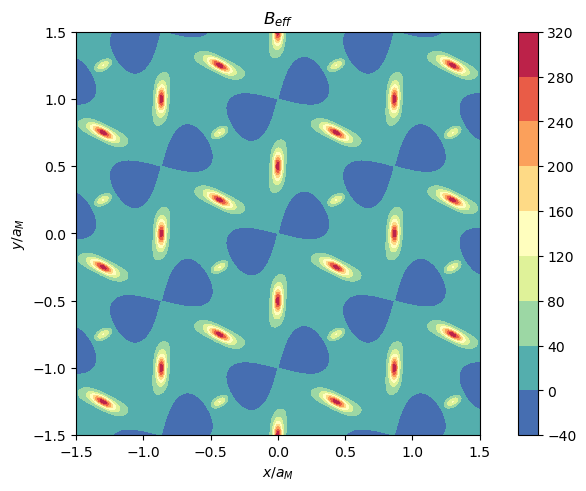

In [8]:
# Plot of B
fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('$B_{eff}$')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, B, levels=9, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

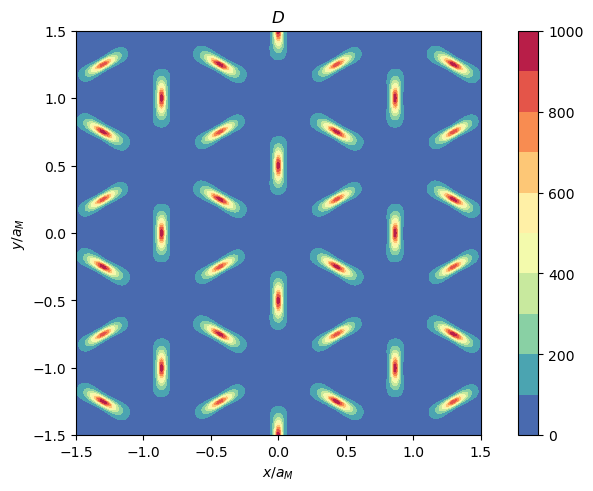

In [9]:
# Plot of D
fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('$D$')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, D, levels=9, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

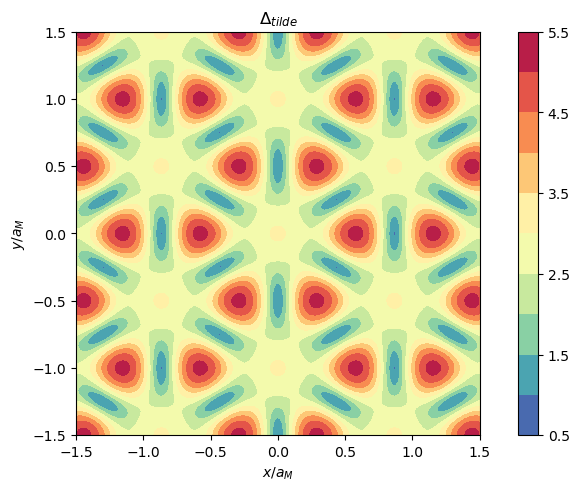

In [10]:
# Plot of Delta tilde
fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('$\Delta_{tilde}$')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, Del_tilde, levels=9, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()


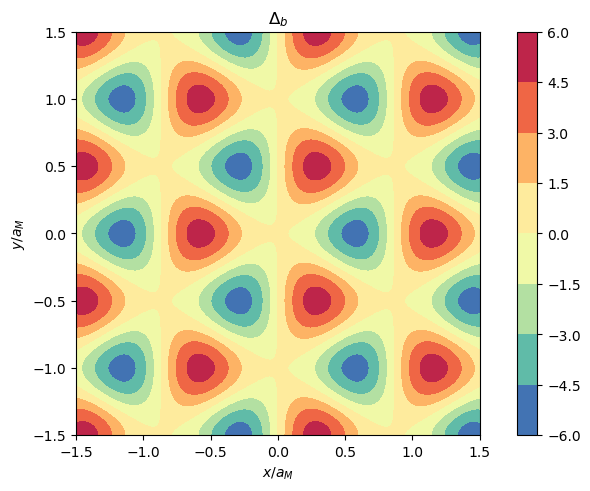

In [11]:
# Plot of \Delta_b
fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('$\Delta_b$')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, Del_b, levels=9, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

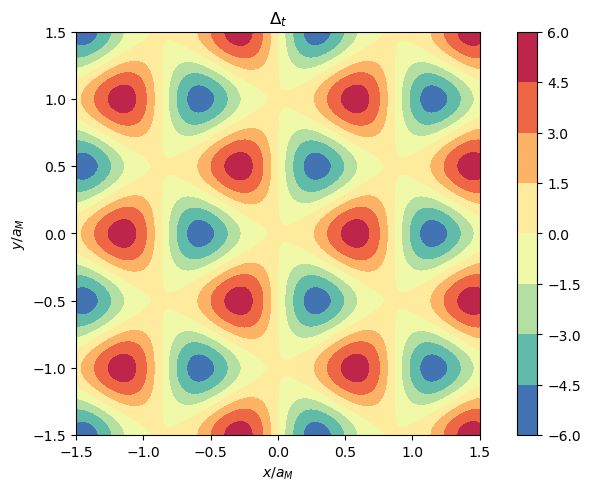

In [12]:
# Plot of \Delta_t
fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('$\Delta_t$')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, Del_t, levels=9, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

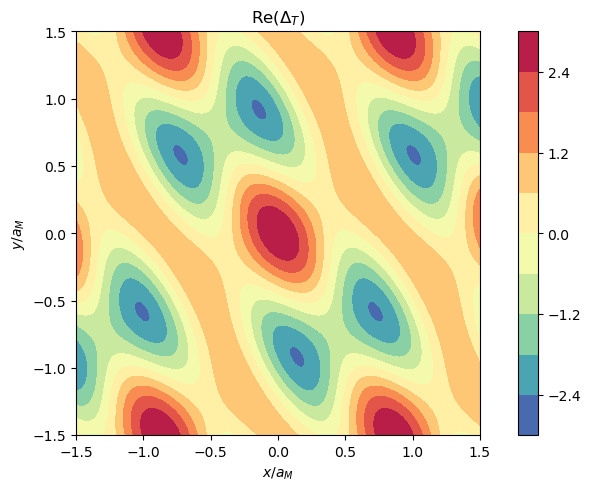

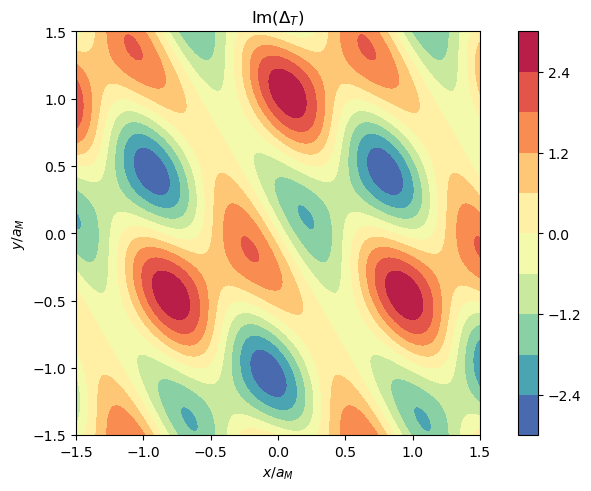

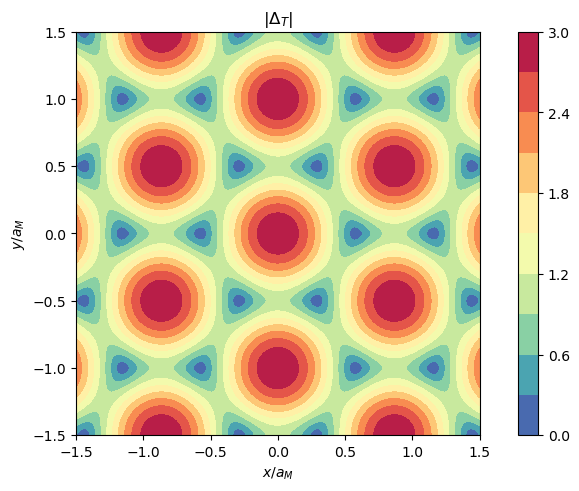

In [13]:
# Plots of \Delta_T: real part, imaginary part, magnitude
fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('Re($\Delta_T$)')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, np.real(Del_T), levels=9, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('Im($\Delta_T$)')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, np.imag(Del_T), levels=9, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('|$\Delta_T$|')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, np.abs(Del_T), levels=9, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()


### Plots of new field a

field is real. 2 components

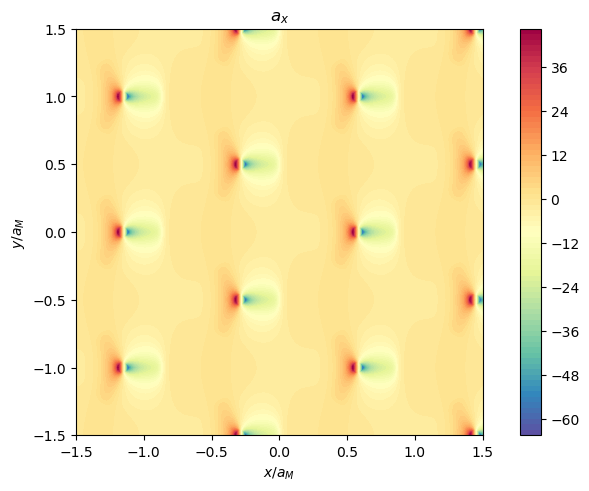

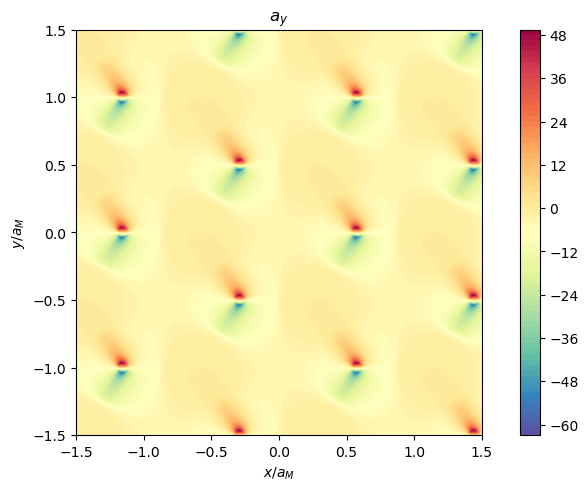

In [14]:
# Plots of a_x
fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('$a_x$')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, a[:,:,0], levels=100, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

# Plots of a_y
fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('$a_y$')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, a[:,:,1], levels=100, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

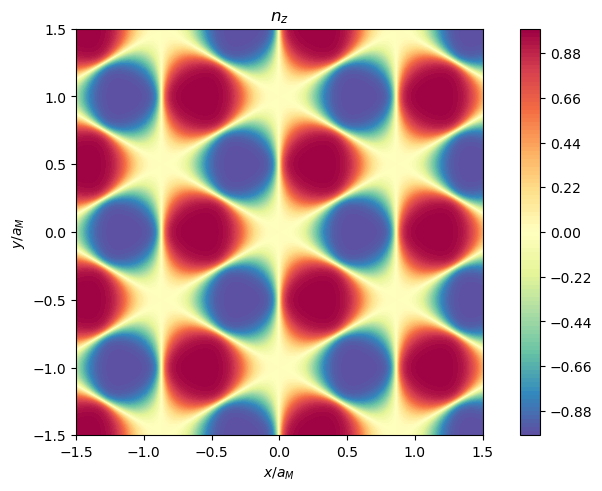

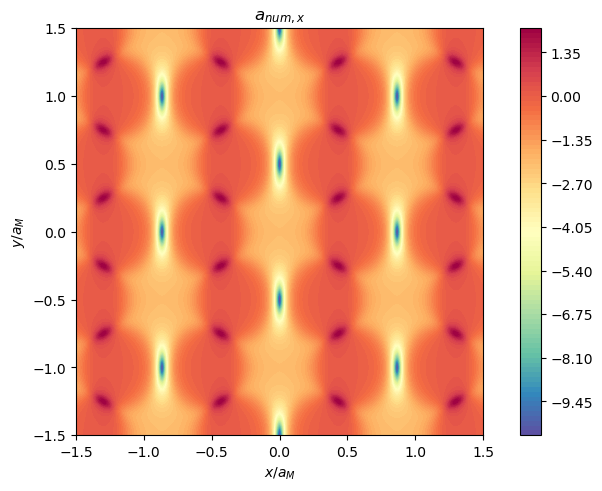

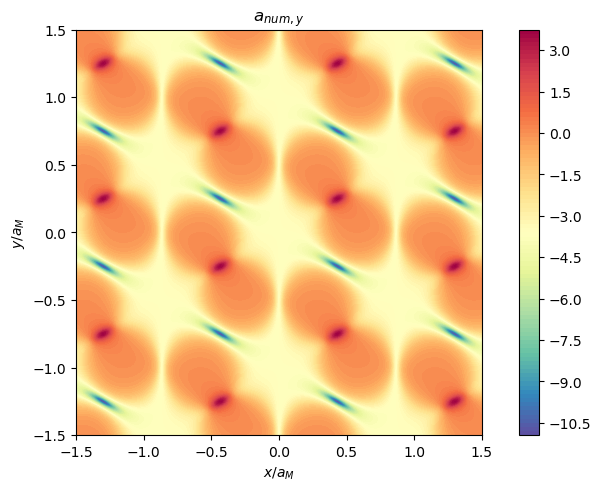

In [17]:
# periodicity test: n_z only, and numerator of a_x only.

fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('$n_z$')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, n[:,:,2], levels=100, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

# numerator of a
a_num = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        a_num[i,j,0] = (n[i,j,0] * n_x[i,j,1] - n[i,j,1] * n_x[i,j,0])
        a_num[i,j,1] = (n[i,j,0] * n_y[i,j,1] - n[i,j,1] * n_y[i,j,0])

fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('$a_{num,x}$')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, a_num[:,:,0], levels=100, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('$a_{num,y}$')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(x, y, a_num[:,:,1], levels=100, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()



